# <center><b><font color='blue'>TRANSFER LEARNING- PARTE 3 </font></b></center>

## 1. Objetivos

Practicarme con Transfer Learning.

## 2. Librerías necesarias

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [42]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


## 3. Helper Functions

In [94]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=256):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size

  
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  return img/255.



def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()



## 4. Carga de datos

In [4]:
seed_value = 57
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
IMG_SHAPE = (256,256)
BATCH_SIZE = 32

train_dir='data/Sports-celebrity images/train'
test_dir='data/Sports-celebrity images/test'

In [4]:
# Configura el generador de datos con solo preprocess_input
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)


# es de notar que NO ponemos rescaling en ImageDataGenerator pues tf.keras.applications.efficientnet
# ya lo incluye


#
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# shuffle es True por defecto


#
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical",
                                             shuffle=False)



Found 315 images belonging to 4 classes.
Found 78 images belonging to 4 classes.
Found 50 images belonging to 4 classes.


In [6]:
num_classes = train_generator.num_classes
num_classes

4

In [7]:
# Obtiene el diccionario que asigna nombres de clases a sus índices
class_indices = train_generator.class_indices
# Invierte el diccionario para obtener un diccionario que asigna índices a nombres de clases
indices_to_classes = {v: k for k, v in class_indices.items()}
# Imprime los nombres de las clases
class_names = list(indices_to_classes.values())
print("Nombres de las clases:", class_names)

Nombres de las clases: ['Kane Williamson', 'Kobe Bryant', 'Maria Sharapova', 'Ronaldo']


## 5. Modelo

In [8]:
checkpoint_path = "checkpoints/model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [10]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=IMG_SHAPE+(3,), name="input_layer")

x = data_augmentation(inputs) # augment images (only happens during training phase)

x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, 
    #stay frozen

x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)

outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainable

In [12]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history = model.fit(train_generator,
                       epochs=5,
                       validation_data=validation_generator,
                       validation_steps=len(validation_generator), 
                       callbacks=[checkpoint_callback])

Epoch 1/5
10/10 [==============================] - 28s 2s/step - loss: 1.3974 - accuracy: 0.3238 - val_loss: 1.2083 - val_accuracy: 0.4872
Epoch 2/5
10/10 [==============================] - 21s 2s/step - loss: 1.1054 - accuracy: 0.5619 - val_loss: 1.0106 - val_accuracy: 0.6026
Epoch 3/5
10/10 [==============================] - 18s 2s/step - loss: 0.9537 - accuracy: 0.6889 - val_loss: 0.8892 - val_accuracy: 0.6923
Epoch 4/5
10/10 [==============================] - 18s 2s/step - loss: 0.8170 - accuracy: 0.7524 - val_loss: 0.7867 - val_accuracy: 0.7821
Epoch 5/5
10/10 [==============================] - 17s 2s/step - loss: 0.6946 - accuracy: 0.8190 - val_loss: 0.7243 - val_accuracy: 0.7692


In [15]:
score1 = model.evaluate(test_generator)

2/2 [==============================] - 2s 638ms/step - loss: 0.7073 - accuracy: 0.7600


In [17]:
print(f"La precisión fue del {round(score1[1],2)*100}%")

La precisión fue del 76.0%


## 6. Fine-tuning

In [18]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [19]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [20]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [21]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [22]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_fine_tune = model.fit(train_generator,
                                 epochs=fine_tune_epochs,
                                 validation_data=validation_generator,
                                 validation_steps=len(validation_generator),
                                 initial_epoch=history.epoch[-1])

Epoch 5/10
10/10 [==============================] - 26s 2s/step - loss: 0.6477 - accuracy: 0.8032 - val_loss: 0.6484 - val_accuracy: 0.8077
Epoch 6/10
10/10 [==============================] - 16s 2s/step - loss: 0.5525 - accuracy: 0.8286 - val_loss: 0.6014 - val_accuracy: 0.8205
Epoch 7/10
10/10 [==============================] - 17s 2s/step - loss: 0.4954 - accuracy: 0.8540 - val_loss: 0.5535 - val_accuracy: 0.8462
Epoch 8/10
10/10 [==============================] - 17s 2s/step - loss: 0.4209 - accuracy: 0.8889 - val_loss: 0.5221 - val_accuracy: 0.8333
Epoch 9/10
10/10 [==============================] - 17s 2s/step - loss: 0.4137 - accuracy: 0.8952 - val_loss: 0.4956 - val_accuracy: 0.8333
Epoch 10/10
10/10 [==============================] - 15s 2s/step - loss: 0.3433 - accuracy: 0.9270 - val_loss: 0.4850 - val_accuracy: 0.8333


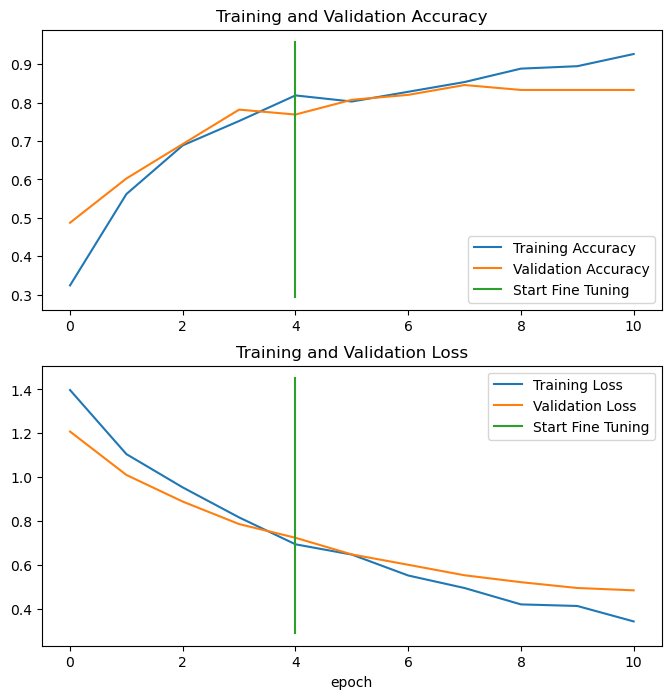

In [26]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history,
                 new_history=history_fine_tune,
                 initial_epochs=5)

Puede apreciarse que se lograron mejoras debido fine tunning.

In [23]:
#save and load model

# Save our fine-tuning model
#model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")
#loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_
#big_dog_model")
#loaded_model_results = loaded_model.evaluate(test_data)
#loaded_model_results

In [27]:
scores2 = model.evaluate(test_generator)

2/2 [==============================] - 2s 754ms/step - loss: 0.4134 - accuracy: 0.8400


In [29]:
print(f"La precisión fue {round(scores2[1],2)*100}%")

La precisión fue 84.0%


## 7. Predicciones

Veamos un poco las predicciones.

In [30]:
# etiquetas reales
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3], dtype=int32)

In [31]:
# Make predictions with model
preds_probs = model.predict(test_generator) 

2/2 [==============================] - 3s 644ms/step


In [32]:
len(preds_probs)

50

In [33]:
preds_probs.shape

(50, 4)

In [34]:
preds_probs[0]

array([0.50844353, 0.0405434 , 0.07275464, 0.37825838], dtype=float32)

vemos que me devolvió la probabilidad para cada clase

In [35]:
sum(preds_probs[0])

0.9999999478459358

In [36]:
# obtenemos la predicción (etiqueta con mayor probabilidad)
pred_classes = np.argmax(preds_probs, axis=1)

In [37]:
pred_classes[0]

0

In [38]:
len(pred_classes)

50

## 8. Análisis de resultados

### Matriz de confusión 

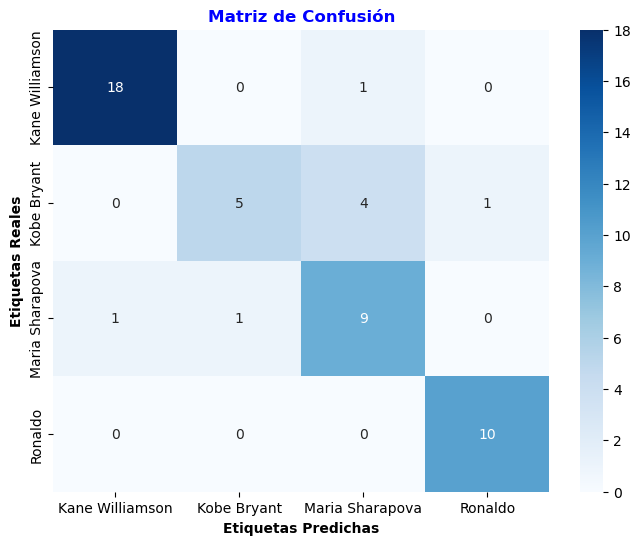

Informe de Clasificación:
                 precision    recall  f1-score   support

Kane Williamson       0.95      0.95      0.95        19
    Kobe Bryant       0.83      0.50      0.62        10
Maria Sharapova       0.64      0.82      0.72        11
        Ronaldo       0.91      1.00      0.95        10

       accuracy                           0.84        50
      macro avg       0.83      0.82      0.81        50
   weighted avg       0.85      0.84      0.83        50



In [99]:
# etiquetas predichas
etiquetas_predichas = pred_classes

# Obtiene las etiquetas reales del generador de prueba
etiquetas_reales = test_generator.classes

# Calcula la matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_reales, etiquetas_predichas)

# Visualiza la matriz de confusión utilizando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, 
            yticklabels=test_generator.class_indices)
plt.xlabel("Etiquetas Predichas",fontweight='bold')
plt.ylabel("Etiquetas Reales",fontweight='bold')
plt.title("Matriz de Confusión",fontweight='bold',color='blue')
plt.show()

# Imprime el informe de clasificación
print("Informe de Clasificación:")
print(classification_report(etiquetas_reales, etiquetas_predichas, target_names=test_generator.class_indices))


Vemos que Sharapova tiene baja precisión y Kobe Bryant un bajo recall.

### Veamos de forma más gráfica el score F1

In [44]:
# Get a dictionary of the classification report

y_labels = etiquetas_reales

classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [47]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Kane Williamson': 0.9473684210526315,
 'Kobe Bryant': 0.625,
 'Maria Sharapova': 0.7200000000000001,
 'Ronaldo': 0.9523809523809523}

In [48]:
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

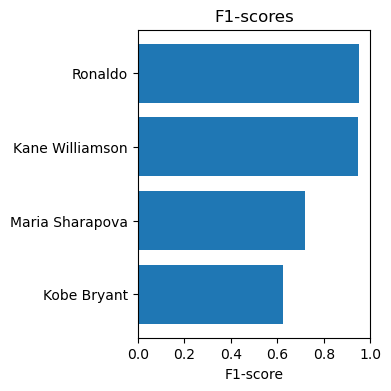

In [57]:
fig, ax = plt.subplots(figsize=(3, 4))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores")
ax.invert_yaxis(); # reverse the order of our plot


###  Viendo las predicciones erróneas

2/2 [==============================] - 2s 665ms/step


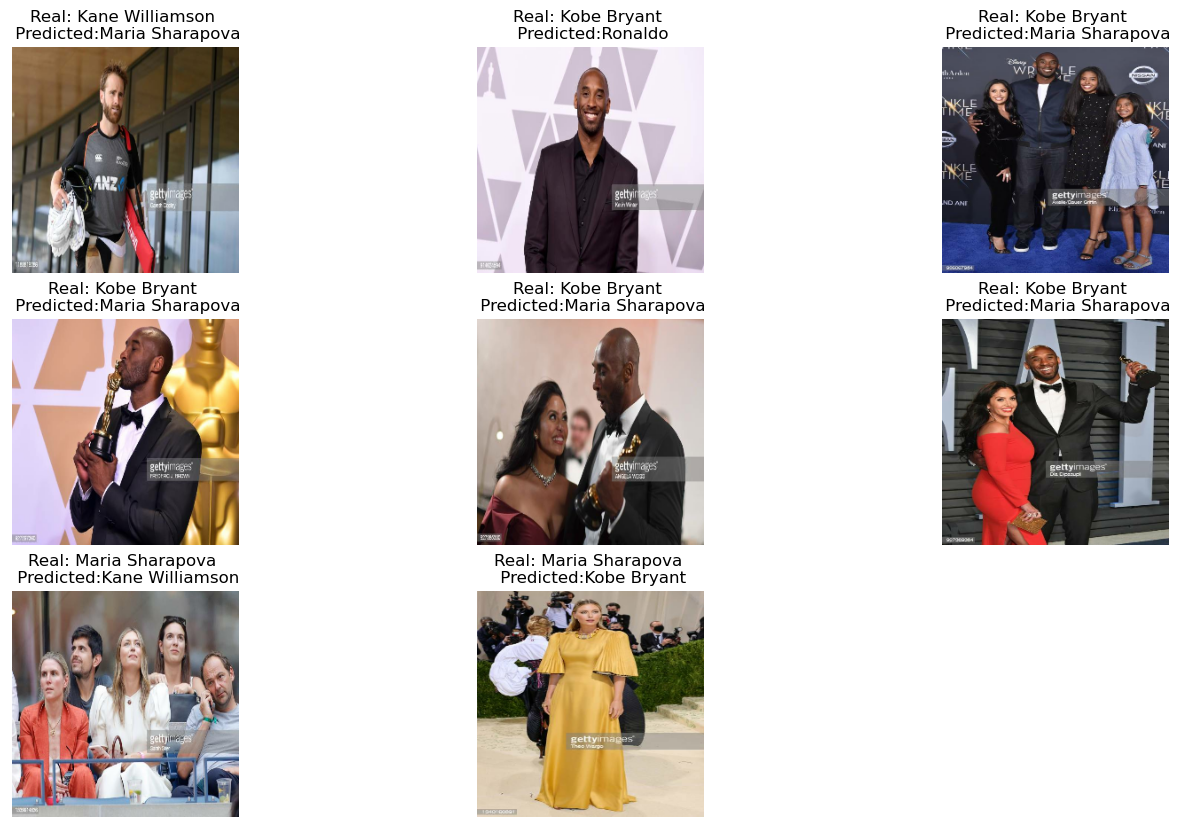

In [92]:
# Supongamos que ya tienes un modelo entrenado llamado 'modelo'
# y 'test_generator' es tu generador de datos de prueba

# Realiza predicciones en el conjunto de prueba
predicciones = model.predict(test_generator)

# Convierte las predicciones en etiquetas predichas
etiquetas_predichas = np.argmax(predicciones, axis=1)

# Obtiene las etiquetas reales del generador de prueba
etiquetas_reales = test_generator.classes

# Encuentra las muestras con predicciones erróneas
muestras_erroneas = np.where(etiquetas_reales != etiquetas_predichas)[0]


# plot
num_columnas = 3
num_filas = len(muestras_erroneas) // num_columnas + 1



plt.figure(figsize=(17, 10))


# Imprime las muestras erróneas y sus etiquetas
#for indice in muestras_erroneas:
for i, indice in enumerate(muestras_erroneas, 1):   
    
    #
    filename = f"data/Sports-celebrity images/test/{test_generator.filenames[indice]}"
    
    img = load_and_prep_image(filename,256)
    
    plt.subplot(num_filas, num_columnas, i)
    plt.title(f"Real: {class_names[etiquetas_reales[indice]]} \n Predicted:{class_names[etiquetas_predichas[indice]]}")
    plt.imshow(img) 
    plt.axis('off')
   
    
    
    #print(f"Nombre de archivo: {test_generator.filenames[indice]}, Etiqueta Real: {etiquetas_reales[indice]}, \
    #      Etiqueta Predicha: {etiquetas_predichas[indice]}")
